In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [26]:
crime_data = pd.read_csv('Crime_Data_from_2020_to_Present.csv')
crime_data.head()
print(crime_data.shape)

(984045, 28)


In [27]:
conn = sqlite3.connect('crime_data.db')
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS crime_data (
        DR_NO TEXT,
        Date_Rptd TEXT,
        DATE_OCC TEXT,
        TIME_OCC INTEGER,
        AREA INTEGER,
        AREA_NAME TEXT,
        Rpt_Dist_No INTEGER,
        "Part 1-2" INTEGER,  
        Crm_Cd INTEGER,
        Crm_Cd_Desc TEXT,
        Vict_Age INTEGER,
        Vict_Sex TEXT,
        Vict_Descent TEXT,
        Premis_Cd INTEGER,
        Premis_Desc TEXT,
        Weapon_Used_Cd INTEGER,
        Weapon_Desc TEXT,
        Status TEXT,
        Status_Desc TEXT,
        Crm_Cd_1 INTEGER, 
        LOCATION TEXT,  
        LAT REAL,
        LON REAL,
        Year INTEGER,
        Hour INTEGER,
        Weekday INTEGER
    ) 
''')
conn.commit()

In [28]:
# Preprocess data
cleaned_crime = crime_data.sample(n=100000, random_state=42)

# Drop non-essential columns
cleaned_crime = cleaned_crime.drop(['Mocodes', 'Cross Street', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4'], axis=1)

# Convert dates to datetime
cleaned_crime['DATE OCC'] = pd.to_datetime(cleaned_crime['DATE OCC'], errors='coerce')
cleaned_crime['Date Rptd'] = pd.to_datetime(cleaned_crime['Date Rptd'], errors='coerce')

# Impute missing categorical data
cleaned_crime['Vict Sex'].fillna('Unknown', inplace=True)
cleaned_crime['Vict Descent'].fillna('Unknown', inplace=True)
cleaned_crime['Weapon Desc'].fillna('Unknown', inplace=True)

# Impute missing numerical data
cleaned_crime['Vict Age'].fillna(cleaned_crime['Vict Age'].median(), inplace=True)
cleaned_crime['Weapon Used Cd'].fillna(0, inplace=True)

# Drop rows with missing critical data
cleaned_crime = cleaned_crime.dropna(subset=['DATE OCC', 'LAT', 'LON'])

# Add additional features if necessary
cleaned_crime['Year'] = cleaned_crime['DATE OCC'].dt.year
cleaned_crime['Hour'] = cleaned_crime['TIME OCC'] // 100
cleaned_crime['Weekday'] = cleaned_crime['DATE OCC'].dt.weekday

# Fill missing values or remove unnecessary columns
cleaned_crime.fillna({'LAT': 0, 'LON': 0}, inplace=True)

# Filter data for valid coordinates
cleaned_crime = cleaned_crime[(cleaned_crime['LAT'] != 0) & (cleaned_crime['LON'] != 0)]

cleaned_crime.info()

/var/folders/g2/yjtfgbx52hnbl1vt88mmg93m0000gn/T/ipykernel_37994/2071292420.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_crime['DATE OCC'] = pd.to_datetime(cleaned_crime['DATE OCC'], errors='coerce')
/var/folders/g2/yjtfgbx52hnbl1vt88mmg93m0000gn/T/ipykernel_37994/2071292420.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_crime['Date Rptd'] = pd.to_datetime(cleaned_crime['Date Rptd'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
Index: 99789 entries, 856479 to 199678
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0       DR_NO       99789 non-null  int64         
 1   Date Rptd       99789 non-null  datetime64[ns]
 2   DATE OCC        99789 non-null  datetime64[ns]
 3   TIME OCC        99789 non-null  int64         
 4   AREA            99789 non-null  int64         
 5   AREA NAME       99789 non-null  object        
 6   Rpt Dist No     99789 non-null  int64         
 7   Part 1-2        99789 non-null  int64         
 8   Crm Cd          99789 non-null  int64         
 9   Crm Cd Desc     99789 non-null  object        
 10  Vict Age        99789 non-null  int64         
 11  Vict Sex        99789 non-null  object        
 12  Vict Descent    99789 non-null  object        
 13  Premis Cd       99788 non-null  float64       
 14  Premis Desc     99737 non-null  object        
 15  W

In [29]:
cleaned_crime.head()
cleaned_crime.isna().sum()
cleaned_crime.columns


Index(['    DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Vict Age',
       'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'LOCATION', 'LAT', 'LON', 'Year', 'Hour', 'Weekday'],
      dtype='object')

In [30]:
cleaned_crime['DATE OCC'] = cleaned_crime['DATE OCC'].dt.strftime('%Y-%m-%d %H:%M:%S')
cleaned_crime['Date Rptd'] = cleaned_crime['Date Rptd'].dt.strftime('%Y-%m-%d %H:%M:%S')

data_tuples = cleaned_crime.values.tolist()

cursor.executemany('''
    INSERT INTO crime_data (
       DR_NO, Date_Rptd, DATE_OCC, TIME_OCC, AREA, AREA_NAME,
       Rpt_Dist_No, "Part 1-2", Crm_Cd, Crm_Cd_Desc, Vict_Age,
       Vict_Sex, Vict_Descent, Premis_Cd, Premis_Desc,
       Weapon_Used_Cd, Weapon_Desc, Status, Status_Desc, Crm_Cd_1,
       LOCATION, LAT, LON, Year, Hour, Weekday
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
''', data_tuples)
conn.commit()

In [31]:
cursor.execute('PRAGMA table_info(crime_data)')
columns = cursor.fetchall()
print(columns)

[(0, 'DR_NO', 'TEXT', 0, None, 0), (1, 'Date_Rptd', 'TEXT', 0, None, 0), (2, 'DATE_OCC', 'TEXT', 0, None, 0), (3, 'TIME_OCC', 'INTEGER', 0, None, 0), (4, 'AREA', 'INTEGER', 0, None, 0), (5, 'AREA_NAME', 'TEXT', 0, None, 0), (6, 'Rpt_Dist_No', 'INTEGER', 0, None, 0), (7, 'Part 1-2', 'INTEGER', 0, None, 0), (8, 'Crm_Cd', 'INTEGER', 0, None, 0), (9, 'Crm_Cd_Desc', 'TEXT', 0, None, 0), (10, 'Vict_Age', 'INTEGER', 0, None, 0), (11, 'Vict_Sex', 'TEXT', 0, None, 0), (12, 'Vict_Descent', 'TEXT', 0, None, 0), (13, 'Premis_Cd', 'INTEGER', 0, None, 0), (14, 'Premis_Desc', 'TEXT', 0, None, 0), (15, 'Weapon_Used_Cd', 'INTEGER', 0, None, 0), (16, 'Weapon_Desc', 'TEXT', 0, None, 0), (17, 'Status', 'TEXT', 0, None, 0), (18, 'Status_Desc', 'TEXT', 0, None, 0), (19, 'Crm_Cd_1', 'INTEGER', 0, None, 0), (20, 'LOCATION', 'TEXT', 0, None, 0), (21, 'LAT', 'REAL', 0, None, 0), (22, 'LON', 'REAL', 0, None, 0), (23, 'Year', 'INTEGER', 0, None, 0), (24, 'Hour', 'INTEGER', 0, None, 0), (25, 'Weekday', 'INTEGER', 

In [32]:
cursor.execute('PRAGMA table_info(crime_data)')
columns_info = cursor.fetchall()
print(columns_info)

[(0, 'DR_NO', 'TEXT', 0, None, 0), (1, 'Date_Rptd', 'TEXT', 0, None, 0), (2, 'DATE_OCC', 'TEXT', 0, None, 0), (3, 'TIME_OCC', 'INTEGER', 0, None, 0), (4, 'AREA', 'INTEGER', 0, None, 0), (5, 'AREA_NAME', 'TEXT', 0, None, 0), (6, 'Rpt_Dist_No', 'INTEGER', 0, None, 0), (7, 'Part 1-2', 'INTEGER', 0, None, 0), (8, 'Crm_Cd', 'INTEGER', 0, None, 0), (9, 'Crm_Cd_Desc', 'TEXT', 0, None, 0), (10, 'Vict_Age', 'INTEGER', 0, None, 0), (11, 'Vict_Sex', 'TEXT', 0, None, 0), (12, 'Vict_Descent', 'TEXT', 0, None, 0), (13, 'Premis_Cd', 'INTEGER', 0, None, 0), (14, 'Premis_Desc', 'TEXT', 0, None, 0), (15, 'Weapon_Used_Cd', 'INTEGER', 0, None, 0), (16, 'Weapon_Desc', 'TEXT', 0, None, 0), (17, 'Status', 'TEXT', 0, None, 0), (18, 'Status_Desc', 'TEXT', 0, None, 0), (19, 'Crm_Cd_1', 'INTEGER', 0, None, 0), (20, 'LOCATION', 'TEXT', 0, None, 0), (21, 'LAT', 'REAL', 0, None, 0), (22, 'LON', 'REAL', 0, None, 0), (23, 'Year', 'INTEGER', 0, None, 0), (24, 'Hour', 'INTEGER', 0, None, 0), (25, 'Weekday', 'INTEGER', 

In [33]:
cursor.execute('SELECT * FROM crime_data')
crimes = cursor.fetchall()

for crime in crimes[:5]:
    print(crime)

cursor.execute('SELECT COUNT(*) FROM crime_data')
counts = cursor.fetchone()[0]
print(counts)

cursor.execute('''
    SELECT Year, COUNT(*) AS crime_count
    FROM crime_data
    GROUP BY Year
    ORDER BY Year
''')
crimes_per_year = cursor.fetchall()

# Print the result
print(crimes_per_year)

('230221724', '2023-11-29 00:00:00', '2023-11-24 00:00:00', 700, 2, 'Rampart', 218, 1, 331, 'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)', 76, 'F', 'H', 101, 'STREET', 0, 'Unknown', 'IC', 'Invest Cont', 331, '1700    PARK                         AV', 34.0754, -118.2595, 2023, 7, 4)
('201413949', '2020-07-18 00:00:00', '2020-07-18 00:00:00', 145, 14, 'Pacific', 1474, 1, 433, 'DRIVING WITHOUT OWNER CONSENT (DWOC)', 0, 'M', 'X', 101, 'STREET', 0, 'Unknown', 'IC', 'Invest Cont', 433, 'LINCOLN', 33.9599, -118.4197, 2020, 1, 5)
('230306290', '2023-02-13 00:00:00', '2023-02-12 00:00:00', 2100, 3, 'Southwest', 328, 1, 330, 'BURGLARY FROM VEHICLE', 21, 'M', 'W', 103, 'ALLEY', 0, 'Unknown', 'AO', 'Adult Other', 330, '700 W  27TH                         ST', 34.0281, -118.2788, 2023, 21, 6)
('201216821', '2020-07-19 00:00:00', '2020-07-19 00:00:00', 1100, 12, '77th Street', 1267, 2, 624, 'BATTERY - SIMPLE ASSAULT', 38, 'F', 'B', 502, 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)', 400, 'S

In [34]:
cursor.execute('''SELECT Crm_Cd, COUNT(*) AS crime_count
FROM crime_data
GROUP BY Crm_Cd
ORDER BY crime_count DESC
LIMIT 10''')
most_common_crime_codes = cursor.fetchall()
print(most_common_crime_codes)

[(510, 11431), (624, 7502), (330, 6337), (354, 6163), (740, 6045), (310, 5893), (230, 5339), (440, 5228), (626, 4533), (420, 4239)]


In [35]:
cursor.execute('''SELECT *
FROM crime_data
WHERE AREA = 1 LIMIT 10''')
area_1 = cursor.fetchall()
print(area_1)

[('200106694', '2020-02-08 00:00:00', '2020-02-08 00:00:00', 1415, 1, 'Central', 111, 1, 420, 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)', 50, 'M', 'H', 101, 'STREET', 0, 'Unknown', 'IC', 'Invest Cont', 420, 'COLLEGE', 34.0644, -118.2387, 2020, 14, 5), ('210119659', '2021-10-27 00:00:00', '2021-10-27 00:00:00', 30, 1, 'Central', 127, 2, 745, 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 0, 'X', 'X', 753, 'DETENTION/JAIL FACILITY', 0, 'Unknown', 'AO', 'Adult Other', 745, '100 N  LOS ANGELES                  ST', 34.0515, -118.2424, 2021, 0, 2), ('240107436', '2024-02-18 00:00:00', '2024-02-18 00:00:00', 1600, 1, 'Central', 119, 2, 624, 'BATTERY - SIMPLE ASSAULT', 25, 'F', 'H', 834, 'LA UNION STATION (NOT LINE SPECIFIC)', 400, 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', 'IC', 'Invest Cont', 624, '800 N  ALAMEDA                      ST', 34.0561, -118.2375, 2024, 16, 6), ('230120833', '2023-09-29 00:00:00', '2023-09-28 00:00:00', 2301, 1, 'Central', 162, 1, 330, 'BURGLARY FROM V

In [36]:
cursor.execute('''SELECT Crm_Cd_Desc, AVG(Vict_Age) AS average_victim_age
FROM crime_data
GROUP BY Crm_Cd_Desc
ORDER BY average_victim_age DESC''')

victim_ages = cursor.fetchall()
print(victim_ages)

[('DISHONEST EMPLOYEE - GRAND THEFT', 63.0), ('PICKPOCKET, ATTEMPT', 59.0), ('THEFT, COIN MACHINE - ATTEMPT', 48.0), ('DOCUMENT WORTHLESS ($200.01 & OVER)', 47.4), ('BUNCO, GRAND THEFT', 46.10892857142857), ('TILL TAP - PETTY ($950 & UNDER)', 46.0), ('PROWLER', 45.0), ('VIOLATION OF TEMPORARY RESTRAINING ORDER', 44.743589743589745), ('THEFT, COIN MACHINE - GRAND ($950.01 & OVER)', 44.0), ('VIOLATION OF RESTRAINING ORDER', 43.03333333333333), ('THEFT FROM MOTOR VEHICLE - ATTEMPT', 42.785714285714285), ('DISTURBING THE PEACE', 41.979729729729726), ('CONTEMPT OF COURT', 41.607594936708864), ('PURSE SNATCHING', 41.6), ('THEFT OF IDENTITY', 41.27519065390232), ('VIOLATION OF COURT ORDER', 41.03624382207578), ('GRAND THEFT / INSURANCE FRAUD', 41.0), ('DISHONEST EMPLOYEE - PETTY THEFT', 41.0), ('BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM', 41.0), ('THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)', 40.983107172528385), ('THEFT, PERSON', 40.855555555555554), ('THEFT FROM PERSO

In [37]:
cursor.execute('''SELECT LON, COUNT(*) AS crime_count
FROM crime_data
GROUP BY Weekday
ORDER BY crime_count DESC''')

total_crimes_weekdays = cursor.fetchall()
print(total_crimes_weekdays)

[(-118.2595, 15394), (-118.4197, 14668), (-118.2624, 14451), (-118.2702, 13945), (-118.3029, 13918), (-118.2916, 13763), (-118.2788, 13650)]


In [43]:
cursor.execute('''SELECT AREA_NAME, COUNT(*) AS crime_count
FROM crime_data
GROUP BY AREA_NAME
ORDER BY crime_count DESC''')

total_crimes_in_areas = cursor.fetchall()
print(total_crimes_in_areas)

[('Central', 6967), ('77th Street', 5935), ('Pacific', 5855), ('Southwest', 5671), ('Southeast', 5254), ('Hollywood', 5186), ('N Hollywood', 4965), ('Wilshire', 4946), ('Olympic', 4921), ('Rampart', 4718), ('West LA', 4614), ('Newton', 4574), ('Northeast', 4364), ('Van Nuys', 4330), ('Harbor', 4169), ('West Valley', 4134), ('Devonshire', 4058), ('Mission', 4046), ('Topanga', 4025), ('Hollenbeck', 3799), ('Foothill', 3258)]


In [48]:
cursor.execute('''SELECT *
FROM crime_data
WHERE DATE_OCC BETWEEN "2020-01-01" AND "2020-12-31"
''')
crimes_2020 = cursor.fetchall()
print(crimes_2020[:5])

[('201413949', '2020-07-18 00:00:00', '2020-07-18 00:00:00', 145, 14, 'Pacific', 1474, 1, 433, 'DRIVING WITHOUT OWNER CONSENT (DWOC)', 0, 'M', 'X', 101, 'STREET', 0, 'Unknown', 'IC', 'Invest Cont', 433, 'LINCOLN', 33.9599, -118.4197, 2020, 1, 5), ('201216821', '2020-07-19 00:00:00', '2020-07-19 00:00:00', 1100, 12, '77th Street', 1267, 2, 624, 'BATTERY - SIMPLE ASSAULT', 38, 'F', 'B', 502, 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)', 400, 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', 'IC', 'Invest Cont', 624, '900 W  84TH                         ST', 33.9624, -118.2883, 2020, 11, 6), ('201505035', '2020-01-22 00:00:00', '2020-01-13 00:00:00', 800, 15, 'N Hollywood', 1516, 2, 903, 'CONTEMPT OF COURT', 28, 'F', 'H', 502, 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)', 0, 'Unknown', 'AA', 'Adult Arrest', 903, '6700    CAMELLIA                     AV', 34.1922, -118.3823, 2020, 8, 0), ('201709450', '2020-05-24 00:00:00', '2020-05-22 00:00:00', 800, 17, 'Devonshire', 1767, 2, 354, 'T

In [49]:
cursor.execute('''SELECT Weapon_Used_Cd, COUNT(*) AS crime_count
FROM crime_data
GROUP BY Weapon_Used_Cd
ORDER BY crime_count DESC
''')
crimes_by_weapon = cursor.fetchall()
print(crimes_by_weapon)

[(0, 66968), (400, 17449), (500, 3679), (511, 2370), (102, 2073), (109, 711), (200, 685), (106, 682), (207, 612), (512, 418), (307, 326), (306, 259), (212, 245), (312, 243), (308, 236), (304, 219), (204, 214), (114, 189), (205, 173), (201, 153), (302, 150), (311, 129), (113, 125), (107, 113), (215, 109), (101, 108), (218, 99), (515, 95), (219, 91), (310, 68), (223, 68), (506, 66), (301, 65), (216, 56), (513, 42), (305, 42), (103, 42), (309, 36), (104, 36), (211, 32), (221, 30), (217, 27), (303, 25), (501, 23), (503, 18), (514, 17), (206, 17), (112, 17), (510, 16), (210, 12), (208, 12), (203, 11), (504, 8), (122, 8), (505, 7), (509, 6), (209, 6), (115, 6), (516, 5), (507, 5), (111, 5), (108, 5), (502, 4), (110, 4), (508, 3), (214, 3), (213, 3), (300, 2), (202, 2), (105, 2), (220, 1), (124, 1), (117, 1), (116, 1)]


In [50]:
cursor.execute('''SELECT Vict_Descent, COUNT(*) AS crime_count
FROM crime_data
GROUP BY Vict_Descent
ORDER BY crime_count DESC
LIMIT 5''')
most_common_descent_victims = cursor.fetchall()
print(most_common_descent_victims)

[('H', 29403), ('W', 19862), ('Unknown', 14321), ('B', 13407), ('X', 10828)]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


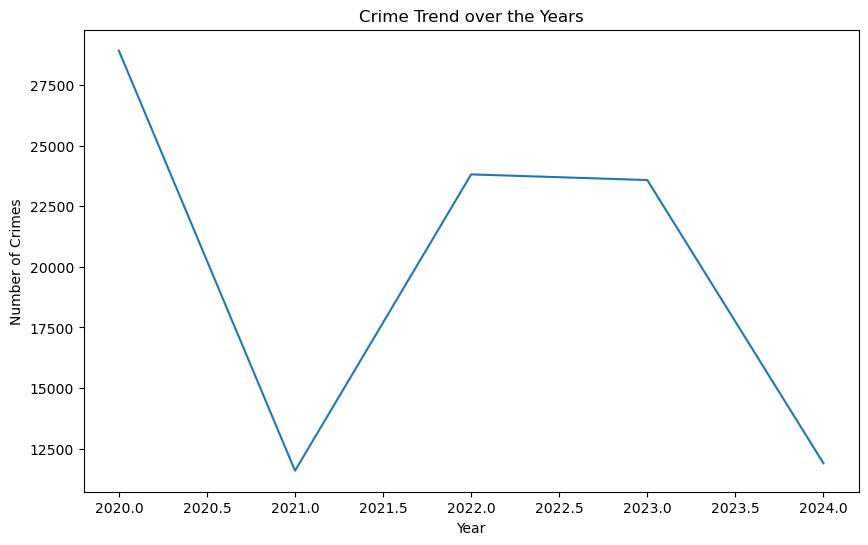

In [38]:
# Convert 'DATE OCC' to datetime format (if it's not already)
cleaned_crime['DATE OCC'] = pd.to_datetime(cleaned_crime['DATE OCC'], errors='coerce')

# Now, extract the year
cleaned_crime['Year'] = cleaned_crime['DATE OCC'].dt.year
yearly_crime = cleaned_crime.groupby('Year').size()


plt.figure(figsize=(10,6))
sns.lineplot(x=yearly_crime.index, y=yearly_crime.values)
plt.title("Crime Trend over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.show()

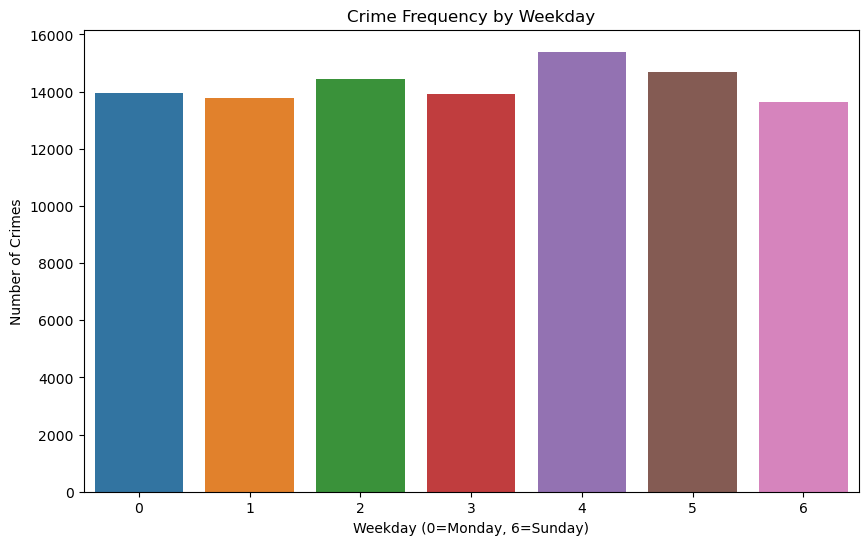

In [52]:
crime_by_weekday = cleaned_crime.groupby('Weekday').size()

plt.figure(figsize=(10,6))
sns.barplot(x=crime_by_weekday.index, y=crime_by_weekday.values)
plt.title("Crime Frequency by Weekday")
plt.xlabel("Weekday (0=Monday, 6=Sunday)")
plt.ylabel("Number of Crimes")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


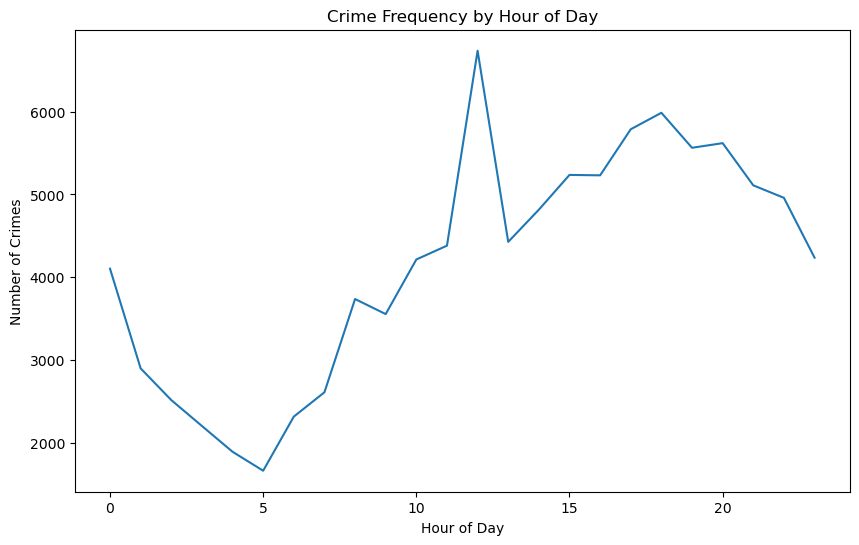

In [53]:
# Plot crime count by hour of day
crime_by_hour = cleaned_crime.groupby('Hour').size()

plt.figure(figsize=(10,6))
sns.lineplot(x=crime_by_hour.index, y=crime_by_hour.values)
plt.title("Crime Frequency by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Crimes")
plt.show()

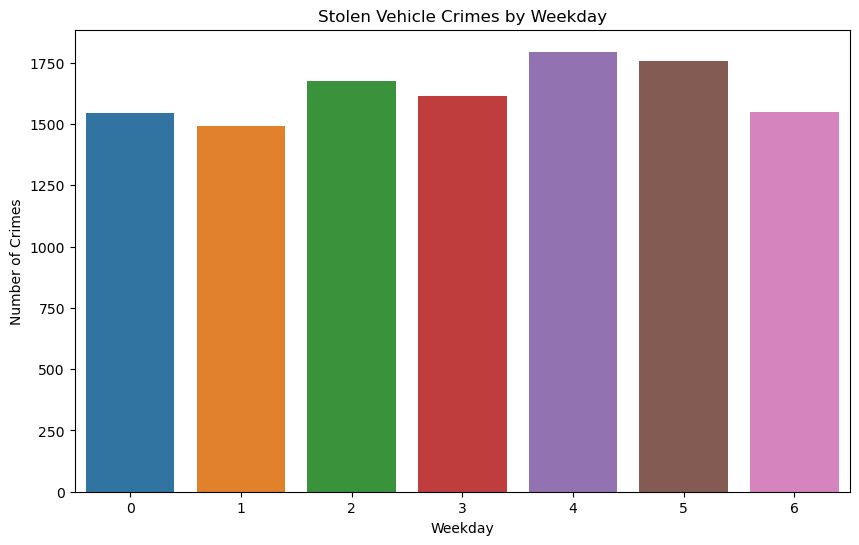

In [54]:
stolen_vehicle_crimes = cleaned_crime[cleaned_crime['Crm Cd'] == 510]

# Plot by weekday, hour, or month
stolen_vehicle_by_weekday = stolen_vehicle_crimes.groupby('Weekday').size()

plt.figure(figsize=(10,6))
sns.barplot(x=stolen_vehicle_by_weekday.index, y=stolen_vehicle_by_weekday.values)
plt.title("Stolen Vehicle Crimes by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Crimes")
plt.show()

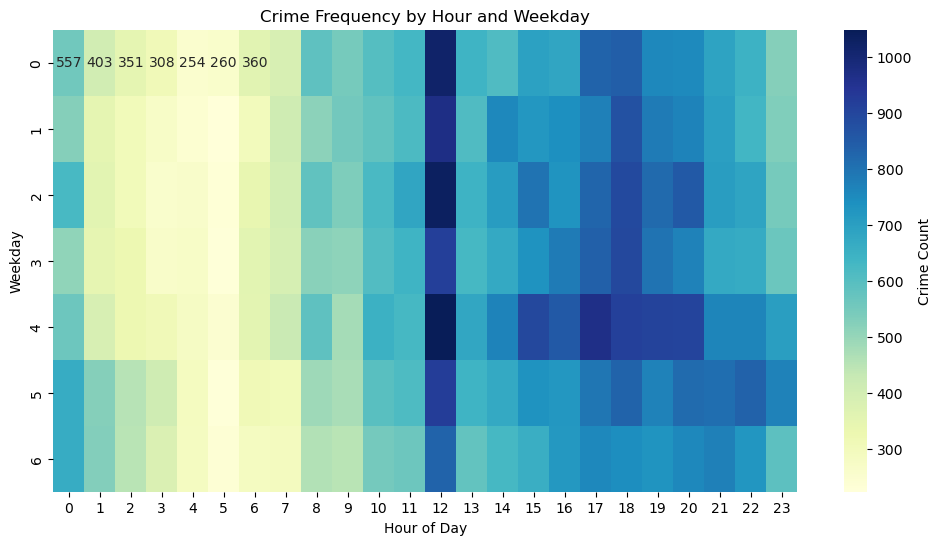

In [55]:
# Pivot data to create a heatmap
crime_heatmap = cleaned_crime.pivot_table(index='Weekday', columns='Hour', aggfunc='size')

plt.figure(figsize=(12,6))
sns.heatmap(crime_heatmap, cmap="YlGnBu", annot=True, fmt="d", cbar_kws={'label': 'Crime Count'})
plt.title("Crime Frequency by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.show()

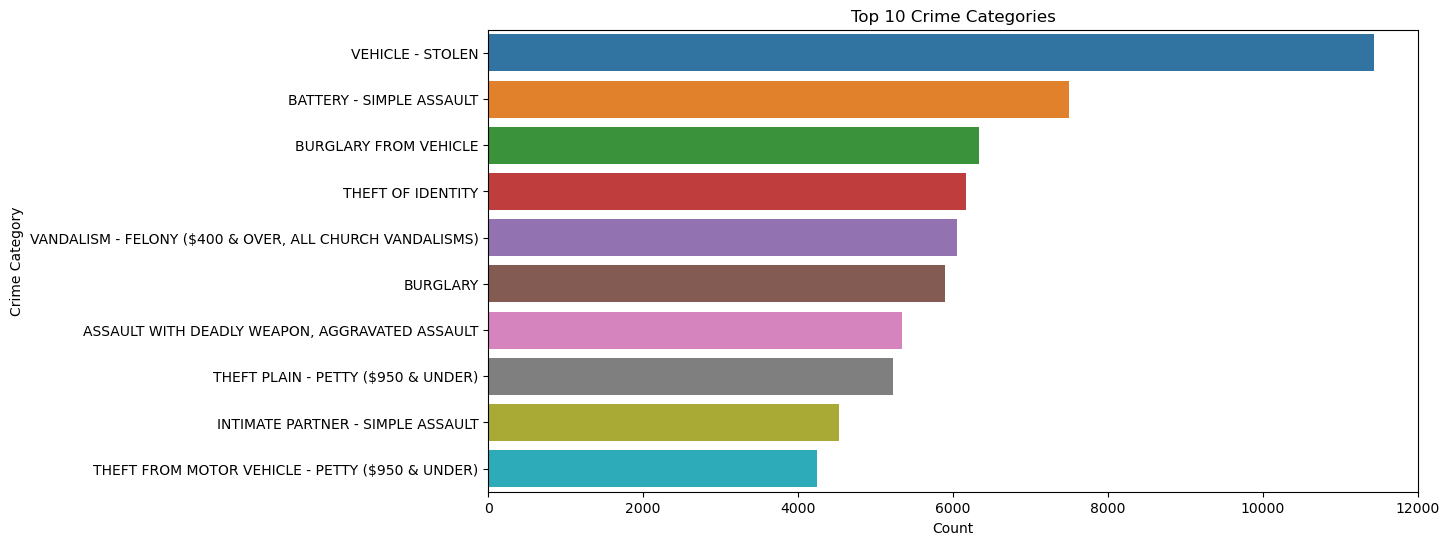

In [39]:
top_crimes = cleaned_crime['Crm Cd Desc'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.countplot(y='Crm Cd Desc', data=cleaned_crime, order=top_crimes.index)
plt.title("Top 10 Crime Categories")
plt.xlabel("Count")
plt.ylabel("Crime Category")
plt.show()

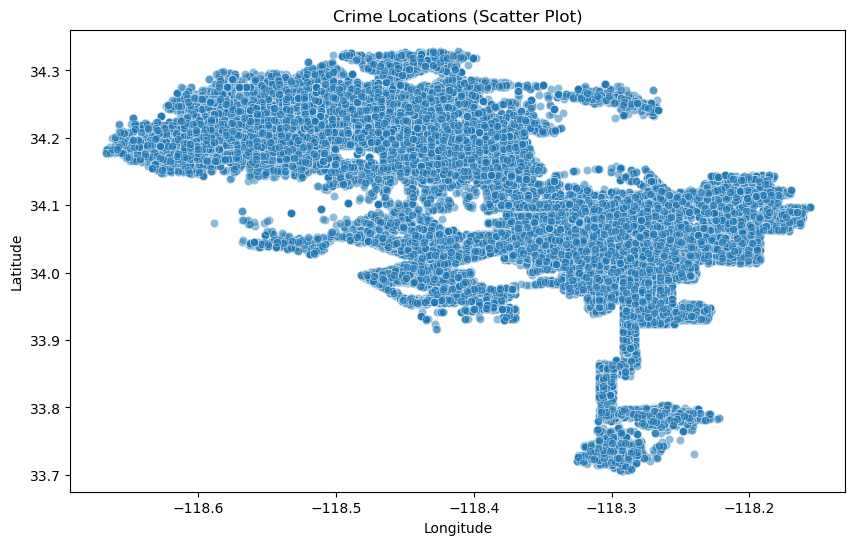

In [40]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LON', y='LAT', data=cleaned_crime, alpha=0.5)
plt.title("Crime Locations (Scatter Plot)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


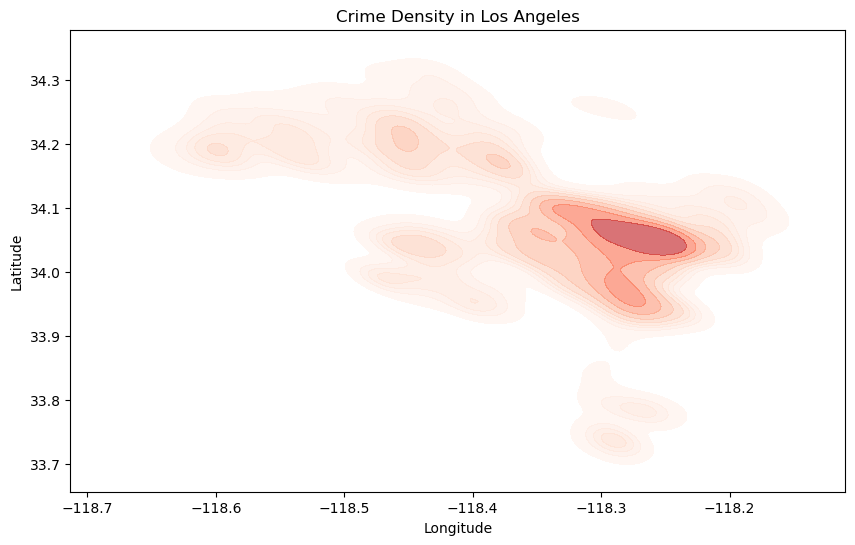

In [41]:
# crime density using kde plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x='LON',
    y='LAT',
    data=cleaned_crime,
    fill=True,
    cmap='Reds',
    alpha=0.6
)
plt.title("Crime Density in Los Angeles")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [42]:
from sklearn.preprocessing import LabelEncoder

# Label encode 'Vict Sex' (binary categorical variable)
label_encoder = LabelEncoder()
cleaned_crime['Vict Sex'] = label_encoder.fit_transform(cleaned_crime['Vict Sex'])

# One-hot encode 'Vict Descent' (if you want to handle it as categorical)
cleaned_crime = pd.get_dummies(cleaned_crime, columns=['Vict Descent'], drop_first=True)

# Handle other categorical variables: 'Premis Cd', 'Weapon Used Cd', 'Status', 'AREA', 'Rpt Dist No'
cleaned_crime = pd.get_dummies(cleaned_crime, columns=['Premis Cd', 'Weapon Used Cd', 'Status', 'AREA'], drop_first=True)

# Now 'Vict Sex' is encoded and 'Vict Descent' has been one-hot encoded
# You can now safely select the features and target
X = cleaned_crime[['Hour', 'Weekday', 'LAT', 'LON', 'Vict Age', 'Vict Sex', 'Year', 'Rpt Dist No'] + 
                  [col for col in cleaned_crime.columns if 'Vict Descent' in col]]
y = (cleaned_crime['Crm Cd'] == 510).astype(int)  # Example: Predicting stolen vehicle crimes

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     17646
           1       0.80      0.96      0.87      2312

    accuracy                           0.97     19958
   macro avg       0.90      0.96      0.93     19958
weighted avg       0.97      0.97      0.97     19958

